# Data Project 2021 - CODE 1161
Soo Young Jang - z5363515

<img src ="introvert.jpeg" width=700 height=500/>

<img src ="leave_on_read.png"/>

<img src ="bff.jpeg"/>

# How does social media reflect my life? 🧐

In [1]:
import datetime
import json
import os
import pickle
import random
import re
import textwrap
from pathlib import Path
from collections import OrderedDict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import message_helpers as mh

In [2]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.sans-serif'] = ['Segoe UI Emoji']

In [3]:
pickle_name = "all_convo.pickle"
pickle_path = Path(pickle_name)

In [4]:
punctuation_regex = r"""
               [,.;:-@#?!&$/\(\)\n\*]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """
STOP_WORDS = [
        "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "did", "do", "does", "doing", "don", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "http", "https", "i", "i'd", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "just", "me", "more", "most", "my", "myself", "no", "nor", "not", "now", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "s", "same", "she", "should", "so", "some", "such", "t", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "were", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "you", "your", "yours", "yourself", "yourselves", "nan", # not a word, accidental cast of NaN
    ]  # https://gist.github.com/sebleier/554280

In [5]:
def parse_obj(obj):
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


def sumarise_convo(name, data, verbose=False):
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    unique_words = set(words[name].split(" "))

    pool = " ".join([str(x) for x in data.content.to_list()]).lower()
    clean = re.sub(mh.PUNCTUATION_REGEX, " ", pool, flags=re.VERBOSE)
    # and replace it with a single space
    stopped = list(set([w for w in clean.split() if w not in mh.STOP_WORDS]))

    if verbose:
        print(
            f"{name} wrote {wordcount} words ({len(words[name])} characters)"
            f" and used {len(stopped)} different words."
        )
    return {
        "participant": name,
        "wordcount": wordcount,
        "unique_words": len(unique_words),
        "cleaned_unique": len(stopped),
    }


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


In [6]:
def load_whole_inbox(rootdir, platform="Facebook"):
    conversations = []
    for d in os.listdir(rootdir):
        conversations.append(d)
    print(f"There are {len(conversations)} conversations to look at from {platform}.")
    # conversations

    convo_df_list = []

    if not pickle_path.is_file():
        for convo in os.listdir(rootdir):
            if ".DS_Store" not in convo:
                for f in os.listdir(os.path.join(rootdir, convo)):
                    try:
                        message_list = []
                        path = os.path.join(os.path.join(rootdir, convo, f))
                        if Path(path).is_file():
                            with open(path, "r") as fb_data:
                                messages = json.load(fb_data, object_hook=parse_obj)
                                message_list.extend(messages["messages"])

                        if len(message_list) != 0:
                            df = pd.DataFrame(message_list)
                            df["source_convo"] = convo
                            df["datetime"] = df.timestamp_ms.apply(
                                lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
                            )

                            if "content" in df.columns:
                                df["message_length"] = df.content.apply(get_message_length)
                                df.content = df.content.apply(
                                    replace_typographic_apostrophy
                                )
                            else:
                                df["message_length"] = 0
                                df["content"] = np.nan

                            df["platform"] = platform

                            convo_df_list.append(df)

                    except Exception as e:
                        print("exception", convo, e)
    return convo_df_list


fb_rootdir = "fb_data/messages/inbox"
fb_convo_df_list = load_whole_inbox(fb_rootdir, platform="Facebook")
ig_rootdir = "insta_data/messages/inbox"
ig_convo_df_list = load_whole_inbox(ig_rootdir, platform="Instagram")
convo_df_list = fb_convo_df_list + ig_convo_df_list
len(convo_df_list)


There are 191 conversations to look at from Facebook.
There are 141 conversations to look at from Instagram.


0

In [7]:
if pickle_path.is_file():
    all_convo_df = pd.read_pickle(pickle_path)
else:
    all_convo_df = pd.concat(convo_df_list, ignore_index=True)
    pd.to_pickle(all_convo_df, pickle_path)
    all_convo_df.sample(10)

In [8]:
def clean_and_stop(content, as_list=False):
    try:
        clean = re.sub(
            mh.PUNCTUATION_REGEX,
            " ",
            content,
            flags=re.VERBOSE,  # and replace it with a single space
        )
        stopped = [w.lower() for w in clean.split() if w.lower() not in mg.STOP_WORDS]
        # print(content, "=>", stopped)
        if as_list:
            return stopped
        else:
            return " ".join(stopped)
    except Exception as e:
        # print(content, e)
        return content


all_convo_df["clean_content"] = all_convo_df.content.apply(clean_and_stop)


In [9]:
print(all_convo_df.shape)
all_convo_df.head(5)

(125857, 21)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,ip,call_duration,share,reactions,gifs,videos,audio_files,missed,users,clean_content
0,,1547017013329,넵,Generic,False,nimxf-gelg,2019-01-09 17:56:53.329,1,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,넵
1,장수영,1547016964711,괜찮아요 다음부터 조심하세요~~,Generic,False,nimxf-gelg,2019-01-09 17:56:04.711,17,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,괜찮아요 다음부터 조심하세요~~
2,,1547016938868,찾았습니다... 감사합니다 정말..,Generic,False,nimxf-gelg,2019-01-09 17:55:38.868,19,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,찾았습니다... 감사합니다 정말..
3,,1547016812510,아지금 3층으로가고있어요,Generic,False,nimxf-gelg,2019-01-09 17:53:32.510,13,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,아지금 3층으로가고있어요
4,장수영,1547016791852,찾으셨나요?,Generic,False,nimxf-gelg,2019-01-09 17:53:11.852,6,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,찾으셨나요?


In [10]:
conv_meta = []
for name, data in all_convo_df.groupby("sender_name"):
    conv_meta.append( sumarise_convo(name, data))
meta_df = pd.DataFrame(conv_meta)
meta_df["ratio"] = meta_df.apply(lambda row: row.wordcount / (row.cleaned_unique+1) , axis=1)


# Who did I talked to most?
The graph clearly shows that I talked to Megan Su a lot. That is my sister. 
Then follow by my high school friend and my other siblings. 

Text(0.5, 1.0, 'Ratio of wordcount to unique words count\n(only showing those with word counts over 1k)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


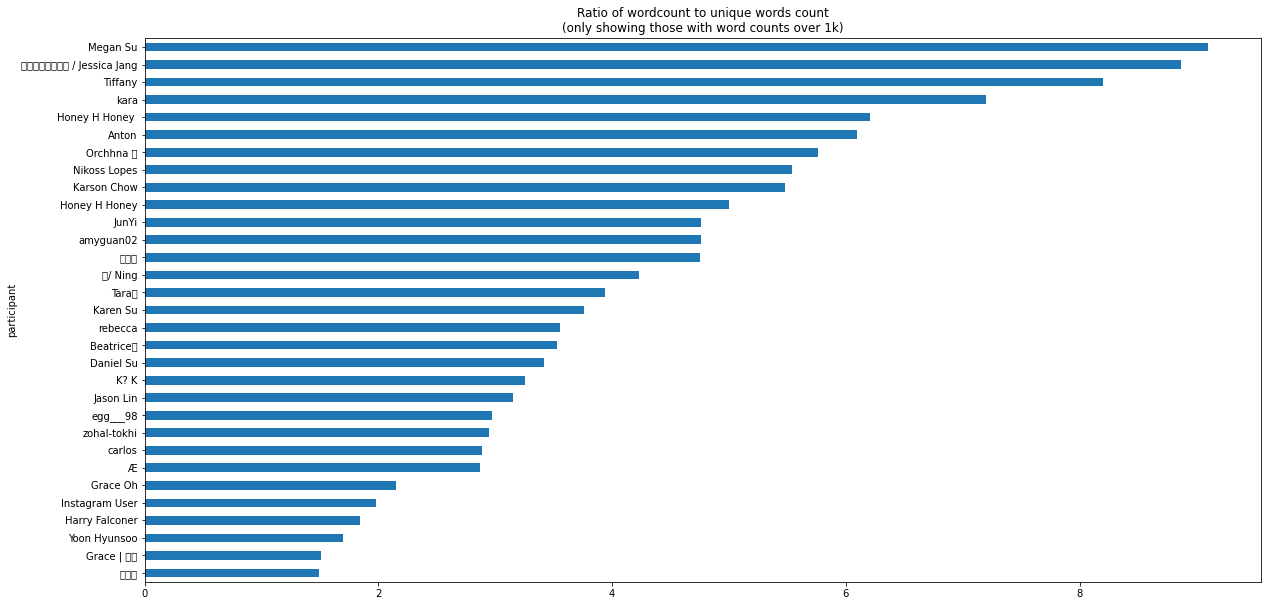

In [11]:
meta_df[meta_df.wordcount>1000].set_index("participant").ratio.sort_values().plot.barh()
plt.title("Ratio of wordcount to unique words count\n(only showing those with word counts over 1k)")

# What relationships did I have with them? and What language do I prefer?

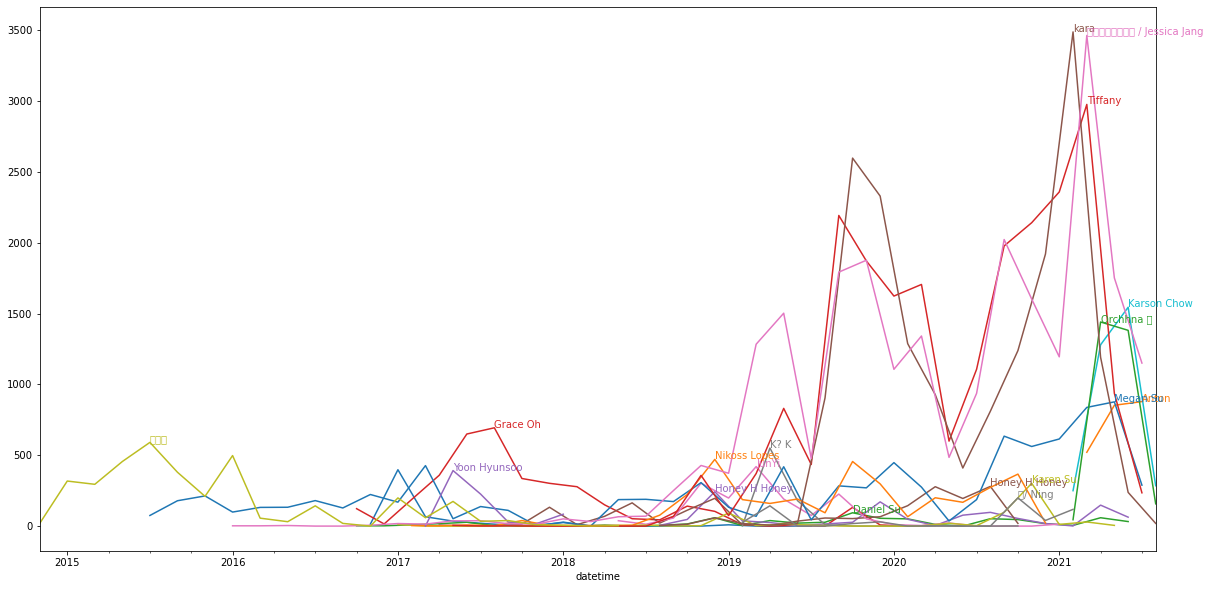

In [12]:
fig, ax = plt.subplots()
for x, d in all_convo_df.groupby("sender_name"):
    if d.shape[0] > 500 and x != "장수영":
        per_period = (
            d.set_index("datetime").groupby(pd.Grouper(freq="2m")).count().sender_name
        )
        per_period.plot()
        col = plt.gca().lines[-1].get_color()
        plt.annotate(x, (per_period.idxmax(), per_period.max()), size=10, color=col)

In [13]:
def has_korean(message):
    try:
        regex = r"[\uac00-\ud7af]|[\u1100-\u11ff]|[\u3130-\u318f]|[\ua960-\ua97f]|[\ud7b0-\ud7ff]"
        matches = re.match(regex, message)
        return matches is not None
    except:
        return False

print(has_korean("hello"))
print(has_korean("장수영"))
all_convo_df["isK"] = all_convo_df.content.apply(has_korean)
all_convo_df.sample(5)

False
True


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,call_duration,share,reactions,gifs,videos,audio_files,missed,users,clean_content,isK
26151,Megan Su,1599176185788,What did u expect,Generic,False,megansu_zepkvzqqpg,2020-09-04 09:36:25.788,17,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,What did u expect,False
29222,Megan Su,1566888656352,Im on the bus home,Generic,False,megansu_zepkvzqqpg,2019-08-27 16:50:56.352,18,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Im on the bus home,False
125107,柠/ Ning,1552193370816,I am wrong,Generic,False,ningning_e95yjhhukg,2019-03-10 15:49:30.816,10,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I am wrong,False
71009,Beatrice🌻,1541823028153,St*,Generic,False,girlschitchat_h1crr4h7xq,2018-11-10 15:10:28.153,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,St*,False
88726,Tiffany,1598711361965,NaN,Generic,False,oshirioshiri_hvg7ktd4na,2020-08-30 00:29:21.965,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Text(0.5, 1.0, 'Korean messages through out the years')

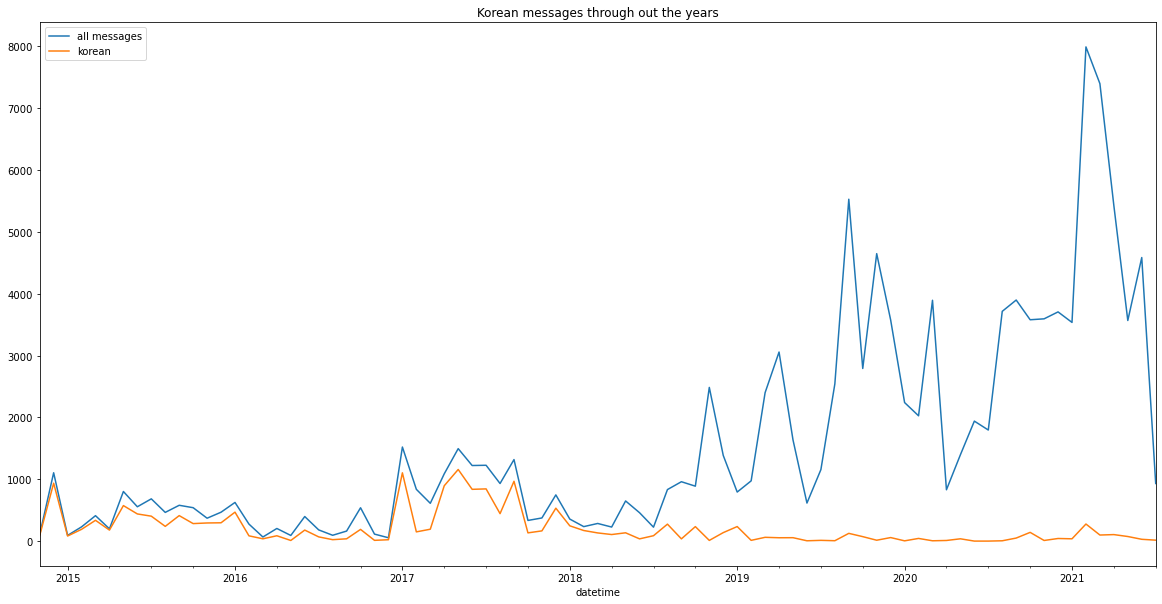

In [14]:
all_convo_df.set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot(label = "all messages")
all_convo_df[all_convo_df.isK].set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot(label = "korean")
plt.legend()
plt.title("Korean messages through out the years")

In [15]:
chatty_people = all_convo_df.sender_name.value_counts() > 100
all_convo_df["chatty_people"] = [chatty_people[x] for x in all_convo_df.sender_name]
all_convo_df.sample(5)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,share,reactions,gifs,videos,audio_files,missed,users,clean_content,isK,chatty_people
56957,Nikoss Lopes,1573459639556,Lucky bitchh,Generic,False,nikosslopes_r5obmmdvqg,2019-11-11 19:07:19.556,12,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lucky bitchh,False,True
15167,Megan Su,1543279704490,Yh?,Generic,False,megansu_zepkvzqqpg,2018-11-27 11:48:24.490,3,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yh?,False,True
67407,장수영 / Jessica Jang,1617446005084,Hahahah nicee,Generic,False,rushhour_pojyki8iva,2021-04-03 21:33:25.084,13,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hahahah nicee,False,True
113897,Tiffany,1623668181047,NaN,Generic,False,oshirioshiri_hvg7ktd4na,2021-06-14 20:56:21.047,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
94053,kara,1586080043929,NaN,Generic,False,oshirioshiri_hvg7ktd4na,2020-04-05 19:47:23.929,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


In [16]:
def time_to_seconds(dt):
    t = dt.time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    return seconds


all_convo_df["date"] = all_convo_df.datetime.apply(lambda x: x.date())
all_convo_df["time"] = all_convo_df.datetime.apply(lambda x: x.time())
all_convo_df["seconds"] = all_convo_df.datetime.apply(time_to_seconds)
all_convo_df.sample(5)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,videos,audio_files,missed,users,clean_content,isK,chatty_people,date,time,seconds
48533,장수영 / Jessica Jang,1549163818852,Haha i was about to talk to you too,Generic,False,junyi_ywursnojla,2019-02-03 14:16:58.852,35,Instagram,NaN,...,NaN,NaN,NaN,NaN,Haha i was about to talk to you too,False,True,2019-02-03,14:16:58.852000,51418
102587,Tiffany,1575024743282,Ur sweatshirt/hoodie,Generic,False,oshirioshiri_hvg7ktd4na,2019-11-29 21:52:23.282,20,Instagram,NaN,...,NaN,NaN,NaN,NaN,Ur sweatshirt/hoodie,False,True,2019-11-29,21:52:23.282000,78743
8850,Honey H Honey,1588320048411,How do you sent her on google classroom,Generic,False,honeyhhoney_4bagrexlvg,2020-05-01 18:00:48.411,39,Facebook,NaN,...,NaN,NaN,NaN,NaN,How do you sent her on google classroom,False,True,2020-05-01,18:00:48.411000,64848
115231,Tiffany,1618378852713,NaN,Generic,False,oshirioshiri_hvg7ktd4na,2021-04-14 15:40:52.713,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,False,True,2021-04-14,15:40:52.713000,56452
85737,kara,1602029362183,if u want bigger boobs just stuff something in...,Generic,False,oshirioshiri_hvg7ktd4na,2020-10-07 11:09:22.183,56,Instagram,NaN,...,NaN,NaN,NaN,NaN,if u want bigger boobs just stuff something in...,False,True,2020-10-07,11:09:22.183000,40162


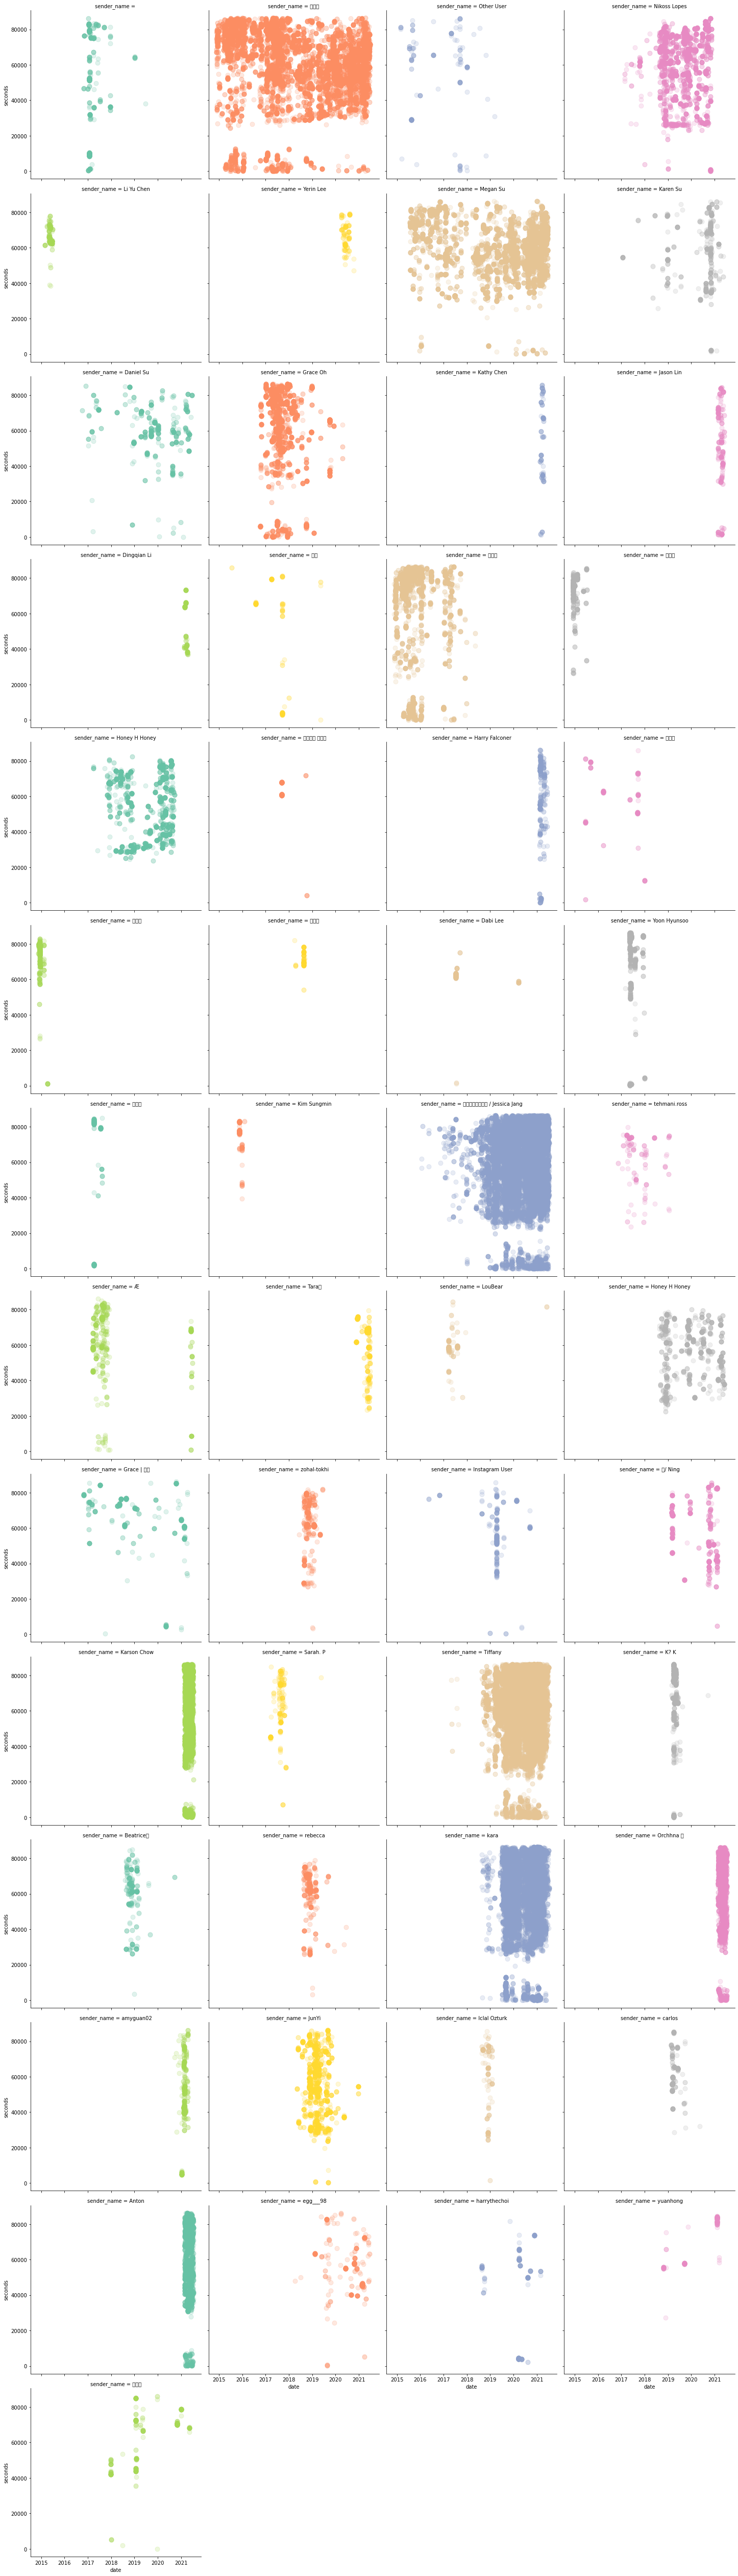

In [17]:
plot = sns.lmplot(
    x="date",
    y="seconds",
    data=all_convo_df[all_convo_df["chatty_people"]],
    # data=all_convo_df,
    hue="sender_name",
    fit_reg=False,
    legend=True,
    palette="Set2",
    col="sender_name",
    col_wrap=4,
    scatter_kws=dict(s=80, alpha=0.2),
)


# Frequently used words
Taking Megan's data as an example.
Shows how much we talked to each other throughout the years. 
I have created wordcloud to show the frequently used words. 

In [18]:
RUN_HEAVY = True 

In [19]:
def parse_obj(obj):
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


rootdir = "fb_data/messages/inbox/megansu_zepkvzqqpg"

message_list = []
participants = []
for p in os.listdir(rootdir):
    path = os.path.join(rootdir, p)
    if Path(path).is_file():
        with open(path, "r") as insta_data:
            messages = json.load(insta_data, object_hook=parse_obj)
            participants = messages["participants"]
            message_list.extend(messages["messages"])


In [20]:
# message_list = messages["messages"]
df = pd.DataFrame(message_list)
df["datetime"] = df.timestamp_ms.apply(
    lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
)


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


df["message_length"] = df.content.apply(get_message_length)
df.content = df.content.apply(replace_typographic_apostrophy)

print(df.shape)
df.sample(5)


(15809, 16)


,sender_name,timestamp_ms,content,type,is_unsent,photos,share,reactions,videos,call_duration,missed,sticker,ip,audio_files,datetime,message_length
9910,장수영,1608175540521,But went i look up cuz i was on my phone the w...,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-17 14:25:40.521,55
1898,장수영,1523596128661,To where?,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-04-13 15:08:48.661,9
7758,Megan Su,1617170510402,Since you only work a couple days how about tr...,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-31 17:01:50.402,55
7134,장수영,1619167580384,Are u gonna get it?,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-23 18:46:20.384,19
5216,장수영,1444898437850,NaN,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,{'uri': 'messages/stickers_used/851582_3692393...,202.161.87.54,NaN,2015-10-15 19:40:37.850,3


In [21]:
unsent = [m for m in message_list if m["is_unsent"]]
period_string = f"{df.datetime.min():%A %d %B, %Y} and {df.datetime.max():%A %d %B, %Y}"
print (
    f"Conversation between {participants[0]['name']} and {participants[1]['name']}.\n"
    f"Covering the period between {period_string}.\n"
    f"In this period there were {len(message_list)} messages, "
    f"{len([x for x in df.photos if x is not np.nan])} photos, "
    f"{len([x for x in df.videos if x is not np.nan])} videos, "
    # f"{len([x for x in df.audio_files if x is not np.nan])} audio files, "
    f"{len(unsent)} messages were unsent"
)

Conversation between Megan Su and 장수영.
Covering the period between Sunday 26 July, 2015 and Tuesday 22 June, 2021.
In this period there were 15809 messages, 496 photos, 11 videos, 7 messages were unsent


Text(0.5, 1.0, 'Total number of messages sent between Sunday 26 July, 2015 and Tuesday 22 June, 2021')

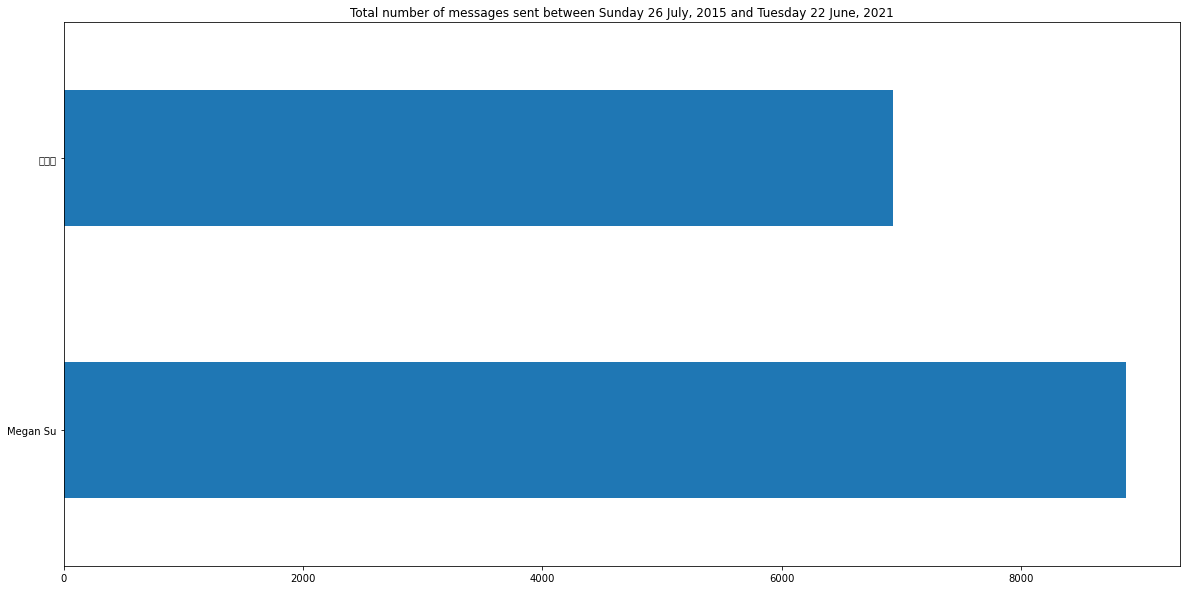

In [22]:
df.sender_name.value_counts().plot.barh()
plt.title(
    f"Total number of messages sent between {period_string}"
)


In [23]:
def sumarise_convo(name, data):
    stop_words = [
        "that's", "i", "i'm", "i'd", "i'll", "it's", "i've", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", 
        "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", 
        "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
        "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
        "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", 
        "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
        "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", 
        "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", 
        "s", "t", "can", "will", "just", "don", "should", "now", "u", "im", "r", "ur", "n", "yh"
    ]  # From: https://gist.github.com/sebleier/554280
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    clean_words = [
        x.lower() for x in words[name].split(" ") if x.lower() not in stop_words
    ]
    unique_words = set(words[name].split(" "))
    print(
        f"Between {period_string}, {name} wrote {wordcount} words ({len(words[name])} characters)"
        f" and used {len(unique_words)} different words."
    )
    # print(unique_words)

    word_freq = pd.Series(clean_words).value_counts()
    top = 40
    # print(word_freq.iloc[:top])
    try:
        word_freq.iloc[:top].plot.barh()
        plt.title(f"{name}'s top {top} most used words")
        plt.tight_layout()
        plt.savefig(f"convo_graphs/{name}'s most used words")
        plt.show()
    except Exception as e:
        print(name, e)
    

In [24]:
def clean_object(x):
    try: 
        return str(x)
    except:
        return np.nan
df["cleanobject"]=df.content.apply(clean_object)
df.head()

,sender_name,timestamp_ms,content,type,is_unsent,photos,share,reactions,videos,call_duration,missed,sticker,ip,audio_files,datetime,message_length,cleanobject
0,Megan Su,1554103419249,Btw couldnt come cuz i need to poop. Been hold...,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-01 18:23:39.249,63,Btw couldnt come cuz i need to poop. Been hold...
1,장수영,1554102247428,Kk,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-01 18:04:07.428,2,Kk
2,Megan Su,1554102243487,Cya,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-01 18:04:03.487,3,Cya
3,Megan Su,1554102241144,Anyways getting motion sick,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-01 18:04:01.144,27,Anyways getting motion sick
4,장수영,1554102217019,Yeh,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-01 18:03:37.019,3,Yeh


Between Sunday 26 July, 2015 and Tuesday 22 June, 2021, Megan Su wrote 34855 words (165995 characters) and used 5158 different words.
Megan Su [Errno 2] No such file or directory: "convo_graphs/Megan Su's most used words.png"
Between Sunday 26 July, 2015 and Tuesday 22 June, 2021, 장수영 wrote 25806 words (120063 characters) and used 4183 different words.
장수영 [Errno 2] No such file or directory: "convo_graphs/장수영's most used words.png"


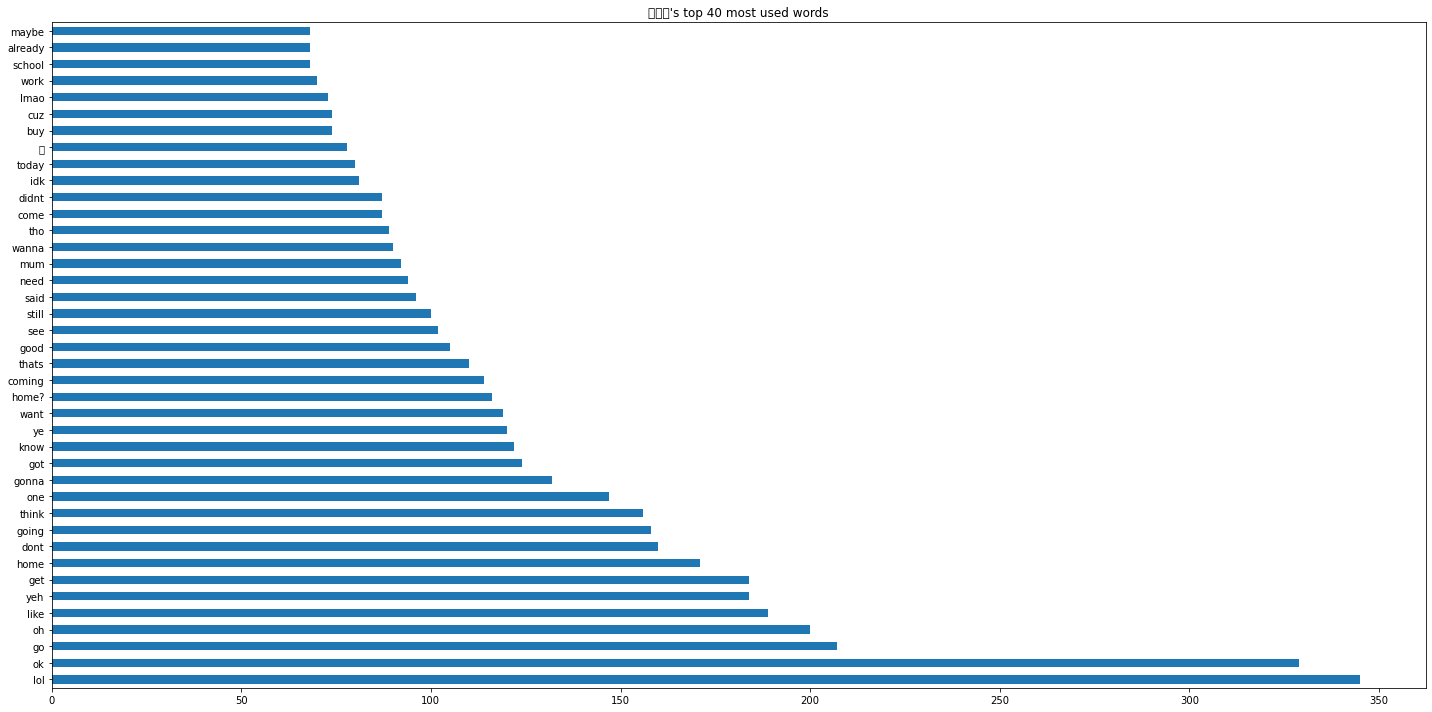

In [25]:
if RUN_HEAVY:
    for name, data in df.groupby("sender_name"):
        sumarise_convo(name, data)

In [26]:
new_df = pd.read_csv("messages.csv")

In [27]:
new_df.head()

,Unnamed: 0,sender_name,timestamp_ms,content,type,is_unsent,photos,share,reactions,videos,call_duration,missed,sticker,ip,audio_files,datetime,message_length,cleanobject
0,0,Megan Su,1.550000e+12,Btw couldnt come cuz i need to poop. Been hold...,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:39.2,63,Btw couldnt come cuz i need to poop. Been hold...
1,1,장수영,1.550000e+12,Kk,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:07.4,2,Kk
2,2,Megan Su,1.550000e+12,Cya,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:03.5,3,Cya
3,3,Megan Su,1.550000e+12,Anyways getting motion sick,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:01.1,27,Anyways getting motion sick
4,4,장수영,1.550000e+12,Yeh,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03:37.0,3,Yeh


In [28]:
words = new_df['content']
words


0        Btw couldnt come cuz i need to poop. Been hold...
1                                                       Kk
2                                                      Cya
3                              Anyways getting motion sick
4                                                      Yeh
                               ...                        
15776                           Hey im going to fisher lib
15777                                                 3:30
15778                                                 soon
15779                             What time u coming home?
15780                                                  Hey
Name: content, Length: 15781, dtype: object

In [33]:
list_of_words = words.to_list()



In [34]:
text = ','.join(str(x) for x in list_of_words)

In [42]:
  stop_words = [
        "that's", "i", "i'm", "i'd", "i'll", "it's", "i've", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", 
        "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", 
        "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
        "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
        "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", 
        "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
        "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", 
        "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", 
        "s", "t", "can", "will", "just", "don", "should", "now", "u", "im", "r", "ur", "n", "yh", "nan"
    ]

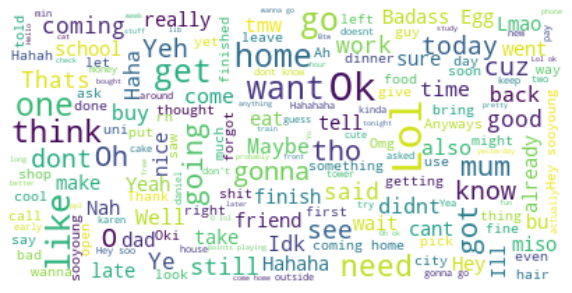

In [43]:
wordcloud = WordCloud(background_color="white",margin=2, min_font_size= 5, max_font_size=30, max_words= 100000, min_word_length=0, stopwords=stop_words).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Finally, how long I do I stay online on social media throughout the years?
This can also help determine my approximate sleep time by looking at the gap between the populated dots  

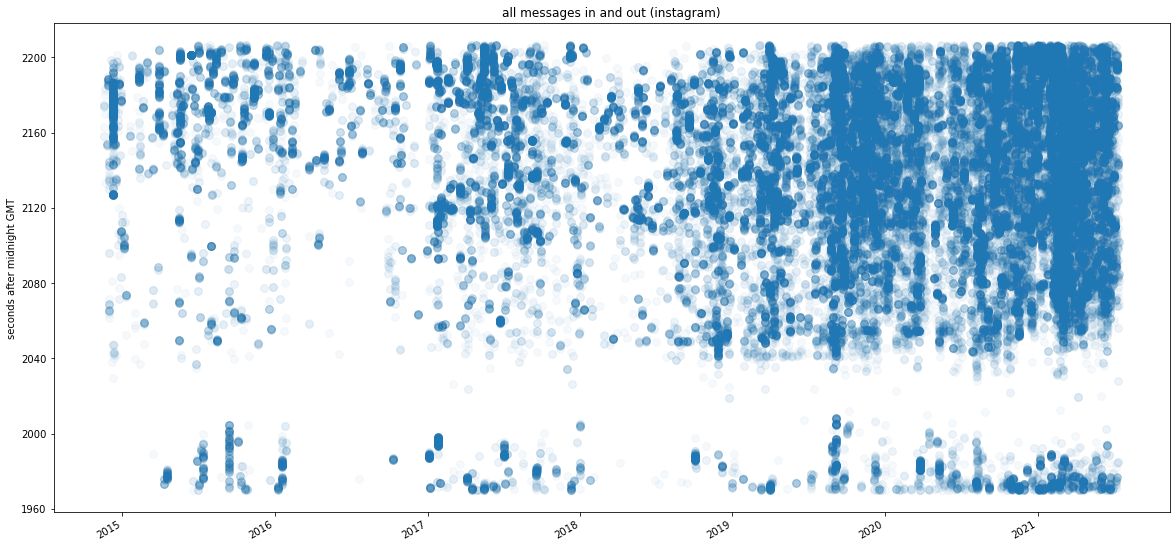

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    all_convo_df.date, all_convo_df.seconds, s=60, alpha=0.04
)  # , c=df.sender_name.astype('category').cat.codes)
ax.yaxis_date()
fig.autofmt_xdate()
plt.title("all messages in and out (instagram)")
plt.ylabel("seconds after midnight GMT")

plt.show()


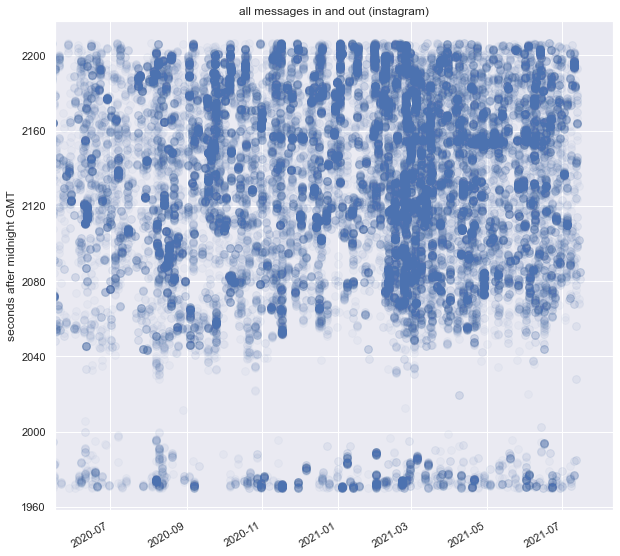

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    all_convo_df.date, all_convo_df.seconds, s=60, alpha=0.04
)  # , c=df.sender_name.astype('category').cat.codes)
ax.yaxis_date()
fig.autofmt_xdate()
plt.title("all messages in and out (instagram)")
plt.ylabel("seconds after midnight GMT")
#plt.xlim(["2020-01-01", "2021-08-01"])
plt.xlim(18400, 18850)
plt.show()

In [40]:
data = all_convo_df[all_convo_df.sender_name != "장수영"]
data = data[data.chatty_people]
print(data.shape)
data.sample(3)


(108105, 26)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,videos,audio_files,missed,users,clean_content,isK,chatty_people,date,time,seconds
54066,장수영 / Jessica Jang,1519887553841,I think one of them was German expressionism,Generic,False,abbie_rfptp8w9ew,2018-03-01 17:59:13.841,44,Instagram,NaN,...,NaN,NaN,NaN,NaN,I think one of them was German expressionism,False,True,2018-03-01,17:59:13.841000,64753
116724,Tiffany,1615881890307,WOW,Generic,False,oshirioshiri_hvg7ktd4na,2021-03-16 19:04:50.307,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,WOW,False,True,2021-03-16,19:04:50.307000,68690
45875,장수영 / Jessica Jang,1613512640478,Okk i brought it but i wasnt sure haha,Generic,False,amyguan02_dd55ulclhw,2021-02-17 08:57:20.478,38,Instagram,NaN,...,NaN,NaN,NaN,NaN,Okk i brought it but i wasnt sure haha,False,True,2021-02-17,08:57:20.478000,32240


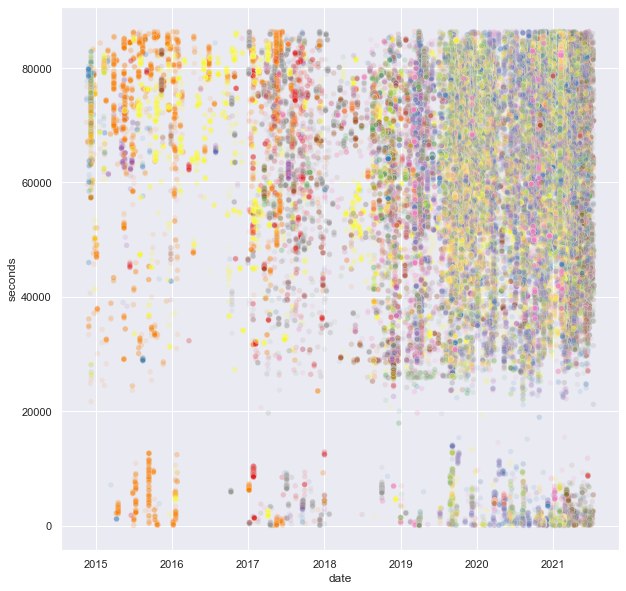

In [44]:
sns.set(rc={"figure.figsize": (10, 10)})
fig, ax = plt.subplots()
g = sns.scatterplot(
    x="date",
    y="seconds",
    data=data,
    hue="sender_name",
    legend=False,
    palette="Set1",
    s=30,
    alpha=0.1,
    ax=ax,
)
# g.legend(bbox_to_anchor=(1.5, 1))